In [ ]:
# Step 1: Upload and Authenticate GCS Key
from google.colab import files
uploaded = files.upload()  # Upload your service account key JSON file
import os

json_filename = list(uploaded.keys())[0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_filename
print(f"Using service account: {json_filename}")

# Step 2: Download Onion dataset from Google Cloud Storage
GCS_URI = "gs://onion11"  # Update this if the URI is different
!mkdir -p OnionData
!gsutil -m cp -r {GCS_URI}/* OnionData/

Streaming output truncated to the last 5000 lines.
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0

In [ ]:
# Step 3: Organize dataset into train/val/test folders
import shutil
import random

base_dir = 'OnionData'
class_id_to_name = {}
classes_txt_path = os.path.join(base_dir, 'classes.txt')

if os.path.exists(classes_txt_path):
    with open(classes_txt_path, 'r') as f:
        for i, line in enumerate(f):
            class_id_to_name[str(i)] = line.strip()

jpgs = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.jpg')}
txts = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.txt')}
paired = [base for base in jpgs if base in txts]

class_to_images = {}
for base in paired:
    with open(os.path.join(base_dir, txts[base]), 'r') as f:
        line = f.readline().strip()
        if not line: continue
        class_id = line.split()[0]
        class_label = class_id_to_name.get(class_id, f"class_{class_id}")
        class_to_images.setdefault(class_label, []).append(jpgs[base])

# Split and copy into train, val, test folders
for split in ['train', 'val', 'test']:
    shutil.rmtree(split, ignore_errors=True)
    for label in class_to_images.keys():
        os.makedirs(os.path.join(split, label), exist_ok=True)

for label, images in class_to_images.items():
    random.shuffle(images)
    total = len(images)
    train_n = int(0.8 * total)
    val_n = int(0.1 * total)

    for img in images[:train_n]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('train', label, img))
    for img in images[train_n:train_n+val_n]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('val', label, img))
    for img in images[train_n+val_n:]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('test', label, img))

In [ ]:
# Step 4: Data Preprocessing and Loading
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder('train', transform=transform)
val_dataset = ImageFolder('val', transform=transform)
test_dataset = ImageFolder('test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Step 5: Define Twins-SVT Model
import torch.nn as nn

class TwinsSVT(nn.Module):
    def __init__(self, num_classes):
        super(TwinsSVT, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

model = TwinsSVT(len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Step 6: Train the Model
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    val_loss, val_corrects = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += (preds == labels).sum().item()
    val_loss /= len(val_dataset)
    val_acc = val_corrects / len(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

training_time = timedelta(seconds=int(time.time() - start_time))

Epoch 1: Train Acc: 0.3776, Val Acc: 0.4057
Epoch 2: Train Acc: 0.5139, Val Acc: 0.5849
Epoch 3: Train Acc: 0.6189, Val Acc: 0.5094
Epoch 4: Train Acc: 0.6790, Val Acc: 0.5943
Epoch 5: Train Acc: 0.7517, Val Acc: 0.5943
Epoch 6: Train Acc: 0.8141, Val Acc: 0.6132
Epoch 7: Train Acc: 0.8741, Val Acc: 0.6698
Epoch 8: Train Acc: 0.9122, Val Acc: 0.6698
Epoch 9: Train Acc: 0.9446, Val Acc: 0.6698
Epoch 10: Train Acc: 0.9596, Val Acc: 0.6415


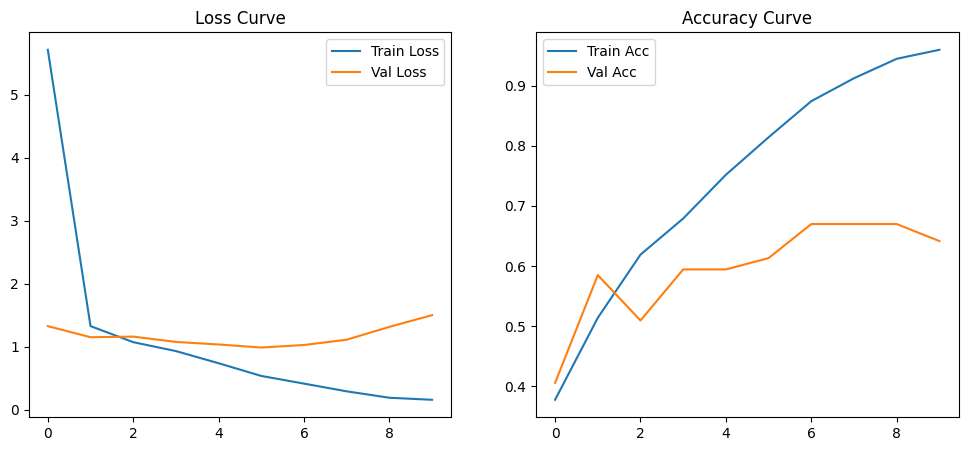


===== Summary =====
Training Accuracy: 95.96%
Validation Accuracy: 64.15%
Test Accuracy: 61.95%
Training Time: 0:31:25
Model Size: 784.30 MB


In [ ]:
# Step 7: Plot Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()

# Step 8: Final Evaluation on Test Set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)

print("\n===== Summary =====")
print(f"Training Accuracy: {train_accuracies[-1] * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracies[-1] * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Training Time: {training_time}")
print(f"Model Size: {model_size:.2f} MB")


Classification Report:
                        precision    recall  f1-score   support

           Anthracnose       0.64      0.68      0.66        31
             Basal_Rot       0.00      0.00      0.00         2
Iris_Yellow_Spot_Virus       0.73      0.96      0.83        25
         Purple_Blotch       0.25      0.50      0.33        10
    Stemphylium_Blight       0.67      0.13      0.22        15
                Thrips       0.75      0.60      0.67        30

              accuracy                           0.62       113
             macro avg       0.51      0.48      0.45       113
          weighted avg       0.65      0.62      0.60       113



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


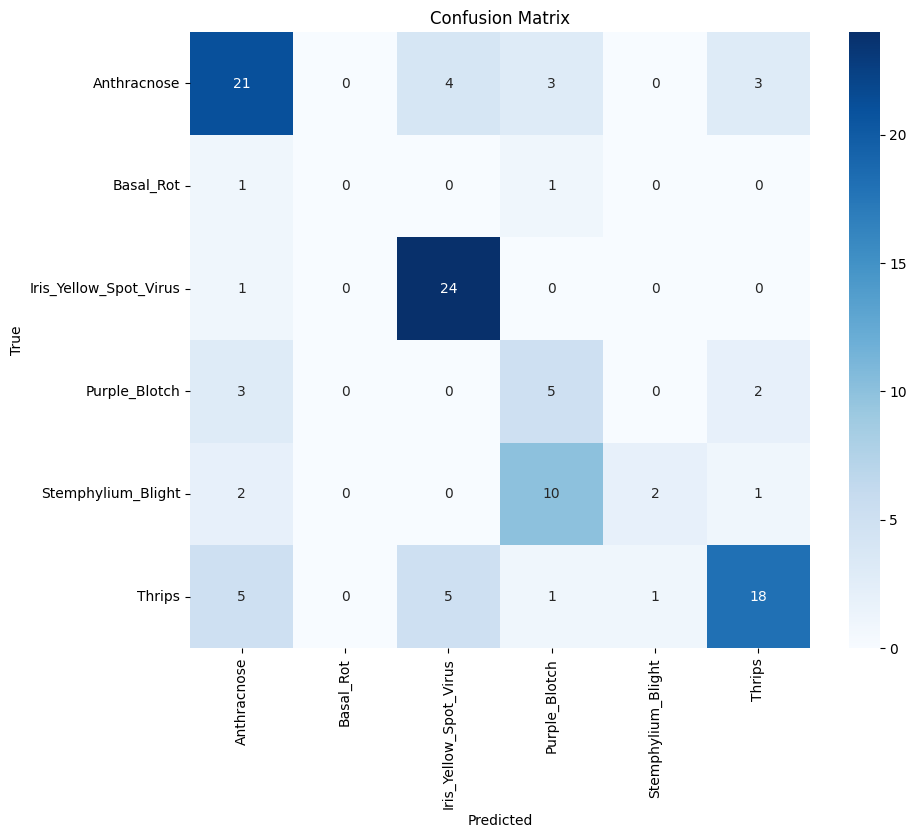

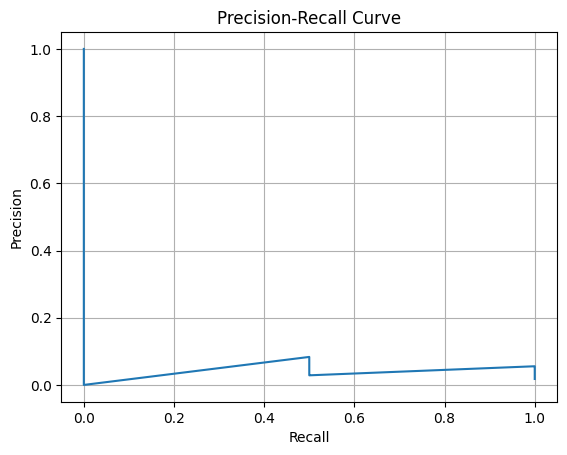

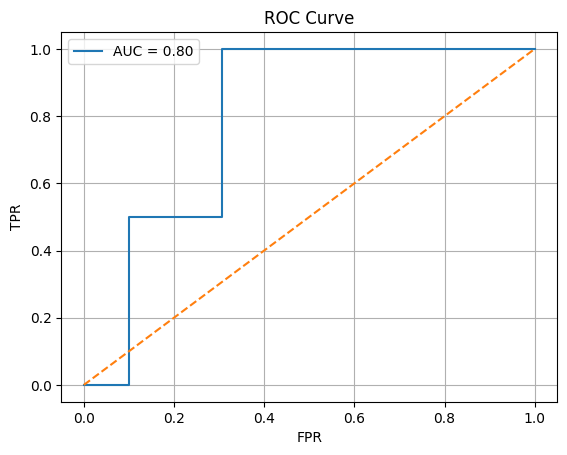

F1 Score (Macro): 0.4510


In [ ]:
# Step 9: Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, roc_curve, auc

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# Step 10: ROC & PR Curves (One-vs-All)
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(all_labels, classes=list(range(len(test_dataset.classes))))
y_pred_probs = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = torch.softmax(model(inputs), dim=1)
        y_pred_probs.extend(outputs.cpu().numpy())

y_pred_probs = np.array(y_pred_probs)

# Precision-Recall Curve for one class (index 1)
precision, recall, _ = precision_recall_curve(y_true_bin[:, 1], y_pred_probs[:, 1])
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True); plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_bin[:, 1], y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.grid(True); plt.show()

# F1 Score
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score (Macro): {f1:.4f}")